# Instacart Market Basket Analysis

# Product Association Analysis and Collaborative Filtering Recommendation System
Drew Malter 
Slalom    
September 2018    

1. [Overview](#Overview)
2. [Import Libraries](#Import-Libraries)
3. [Read In Data](#Read-In-Data)
4. [Data Exploration of Order Tendencies](#Data-Exploration-of-Order-Tendencies)
5. [Product, Aisle, and Department Data Analysis](#Product,-Aisle,-and-Department-Data-Analysis)
6. [Reorder Analysis](#Reorder-Analysis)
7. [Product Association Analysis](#Product-Association-Analysis)
8. [Deep Learning Collaborative Filtering Recommender System](Collaborative-Filtering-Recommender-System)

# Overview

Whether you shop from meticulously planned grocery lists or let whimsy guide your grazing, our unique food rituals define who we are. Instacart, a grocery ordering and delivery app, aims to make it easy to fill your refrigerator and pantry with your personal favorites and staples when you need them. After selecting products through the Instacart app, personal shoppers review your order and do the in-store shopping and delivery for you.

Instacart’s data science team plays a big part in providing this delightful shopping experience. Currently they use transactional data to develop models that predict which products a user will buy again, try for the first time, or add to their cart next during a session. Recently, Instacart open sourced this data - see their blog post on 3 Million Instacart Orders, Open Sourced.

In this competition, Instacart is challenging the Kaggle community to use this anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order. They’re not only looking for the best model, Instacart’s also looking for machine learning engineers to grow their team.

# Import Libraries

In [51]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
color = sns.color_palette()

%matplotlib inline

import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity 

pd.options.mode.chained_assignment = None  # default='warn'

# Read in Data

In [3]:

os.chdir(r'C:\Users\craig.snortheim\Documents\Datasets\Instacart')
df_aisles = pd.read_csv('aisles.csv')
df_departments = pd.read_csv('departments.csv')
df_order_products_prior = pd.read_csv('order_products__prior.csv')
df_order_products_train = pd.read_csv('order_products__train.csv')
df_orders = pd.read_csv('orders.csv')
df_products = pd.read_csv('products.csv')

# Look at Data

In [7]:
df_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
df_order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
df_order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [10]:
df_products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [11]:
df_departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [12]:
df_aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [13]:
#Count rows in the data sets
cnt_records = df_orders.eval_set.value_counts()
cnt_records

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [10]:
print('Number of Orders:...............' + str((df_order_products_prior['order_id'].count())))
print('Number of Unique Products:......' + str((len(df_products['product_name'].unique()))))
print('Number of Unique Aisles:........' + str((len(df_aisles['aisle'].unique()))))
print('Number of Unique Departments:...' + str((len(df_departments['department'].unique()))))
print('Number of Unique Customers:.....' + str((len(df_orders['user_id'].unique()))))

Number of Orders:...............32434489
Number of Unique Products:......49688
Number of Unique Aisles:........134
Number of Unique Departments:...21
Number of Unique Customers:.....206209


# Data Exploration of Order Tendencies

Orders by Day of Week

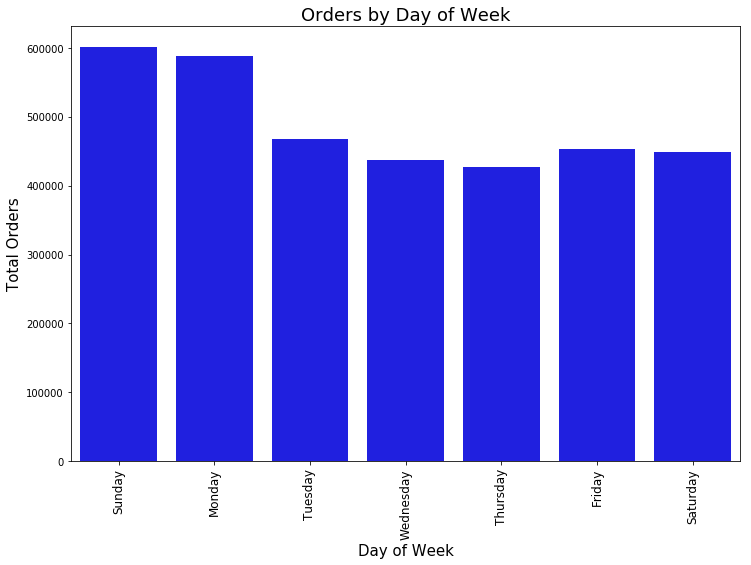

In [12]:
#Orders by Day of Week

df_orders['dayofweek'] = np.where(df_orders['order_dow']==0, 'Sunday', 
                                  np.where(df_orders['order_dow']==1, 'Monday',
                                           np.where(df_orders['order_dow']==2, 'Tuesday',
                                                    np.where(df_orders['order_dow']==3, 'Wednesday',
                                                             np.where(df_orders['order_dow']==4, 'Thursday',
                                                                      np.where(df_orders['order_dow']==5
                                                                               , 'Friday', 'Saturday'))))))




plt.figure(figsize=(12,8))
sns.countplot(x="dayofweek", data=df_orders, color='b', order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday'
                                                                     ,'Thursday', 'Friday', 'Saturday'])
plt.ylabel('Total Orders', fontsize=15)
plt.xlabel('Day of Week', fontsize=15)
plt.xticks(rotation='vertical', fontsize = 12)
plt.title("Orders by Day of Week", fontsize=18)
plt.show()


Orders by hour of day

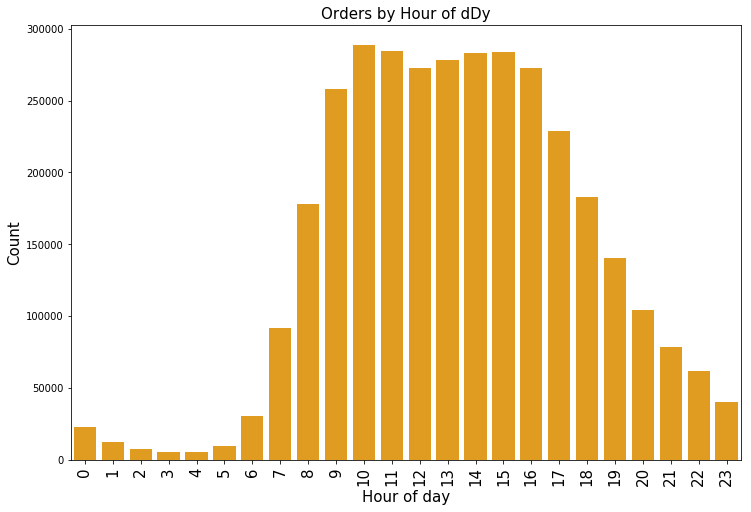

In [14]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=df_orders, color = 'orange')
plt.ylabel('Count', fontsize=15)
plt.xlabel('Hour of day', fontsize=15)
plt.xticks(rotation='vertical', fontsize = 15)
plt.title("Orders by Hour of dDy", fontsize=15)
plt.show()

orders by hour and day of week

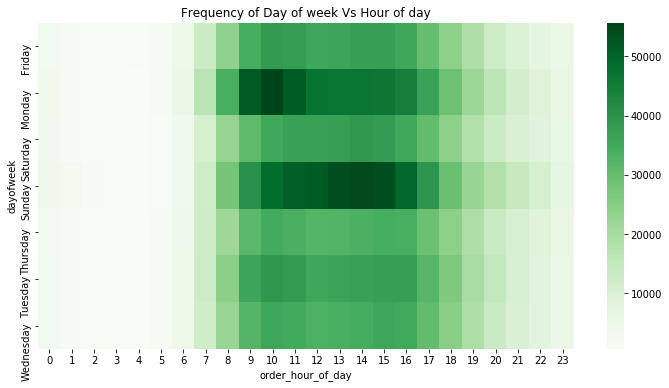

In [17]:
df_time_series = df_orders.groupby(
   ['order_dow','dayofweek', 'order_hour_of_day']
).agg(
    {
        'order_number': 'count'
              
    }
).reset_index()


df_time_series = df_time_series.pivot('dayofweek', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(data = df_time_series, cmap="Greens")
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

Orders by days since previous order

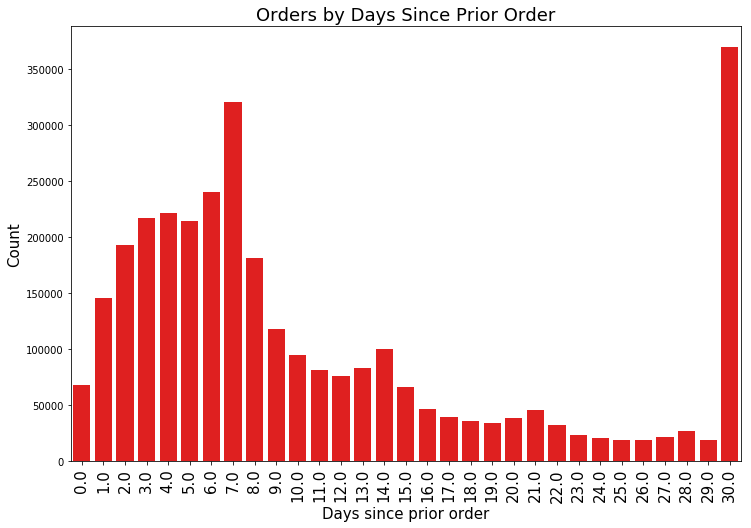

In [18]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=df_orders, color= 'r')
plt.ylabel('Count', fontsize=15)
plt.xlabel('Days since prior order', fontsize=15)
plt.xticks(rotation='vertical', fontsize = 15)
plt.title("Orders by Days Since Prior Order", fontsize=18)
plt.show()

Percent of products that have a reorder

In [26]:
percent_reorder = df_order_products_prior.reordered.sum() / df_order_products_prior.shape[0]
print ('Percent of Products that get Reordered: ' + str(round(percent_reorder * 100, 2)) + '%')

Percent of Products that get Reordered: 58.97%


In [27]:
# percentage of re-orders in train set 
percent_reorder = df_order_products_train.reordered.sum() / df_order_products_train.shape[0]
print ('Percent of Products that get Reordered in Train Set: ' + str(round(percent_reorder * 100, 2)) + '%')

Percent of Products that get Reordered in Train Set: 59.86%


Number of Products in Each order

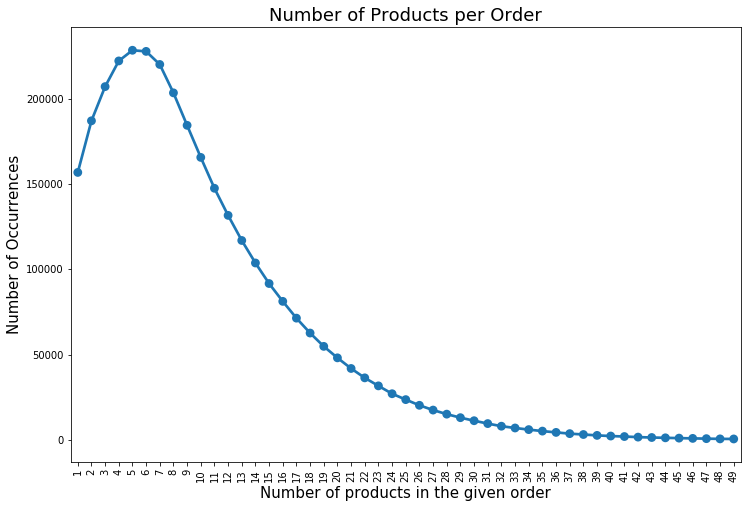

In [37]:
df_grouped = df_order_products_prior.groupby(
   ['order_id']
).agg(
    {
        'add_to_cart_order': 'max'
              
    }
)

df_grouped= df_grouped.loc[df_grouped['add_to_cart_order'] < 50]

cnt_prods = df_grouped.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.pointplot(cnt_prods.index, cnt_prods.values, alpha=0.8)
plt.title("Number of Products per Order", fontsize=18)
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Number of products in the given order', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

# Product, Aisle, and Department Data Analysis

In [42]:
# Join product, aisle, and department infor into the prior order data
df_order_products_prior = pd.merge(df_order_products_prior, df_products, on='product_id', how='left')
df_order_products_prior = pd.merge(df_order_products_prior, df_aisles, on='aisle_id', how='left')
df_order_products_prior = pd.merge(df_order_products_prior, df_departments, on='department_id', how='left')
df_order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


Most ordered products, aisles, departments

In [63]:
#Top ordered products
cnt_products = df_order_products_prior.groupby(
   ['product_name']
).agg(
    {
        'order_id': 'count'
              
    }
).reset_index()

cnt_products = cnt_products.rename(columns={'order_id': 'NumberOfOrders'})
cnt_products = cnt_products.sort_values(by = 'NumberOfOrders', ascending = False)
cnt_products.head(10)

,product_name,NumberOfOrders
3676,Banana,472565
3471,Bag of Organic Bananas,379450
31920,Organic Strawberries,264683
28840,Organic Baby Spinach,241921
30297,Organic Hass Avocado,213584
28804,Organic Avocado,176815
22413,Large Lemon,152657
42904,Strawberries,142951
23420,Limes,140627
32478,Organic Whole Milk,137905


In [67]:
#Top ordered aisles
cnt_aisles = df_order_products_prior.groupby(
   ['aisle']
).agg(
    {
        'order_id': 'count'
              
    }
).reset_index()

cnt_aisles = cnt_aisles.rename(columns={'order_id': 'NumberOfOrders'})
cnt_aisles = cnt_aisles.sort_values(by = 'NumberOfOrders', ascending = False)
cnt_aisles.head(10)

,aisle,NumberOfOrders
50,fresh fruits,3642188
53,fresh vegetables,3418021
98,packaged vegetables fruits,1765313
133,yogurt,1452343
93,packaged cheese,979763
83,milk,891015
131,water seltzer sparkling water,841533
25,chips pretzels,722470
119,soy lactosefree,638253
11,bread,584834


In [65]:
#top ordered departments
cnt_departments = df_order_products_prior.groupby(
   ['department']
).agg(
    {
        'order_id': 'count'
              
    }
).reset_index()

cnt_departments = cnt_departments.rename(columns={'order_id': 'NumberOfOrders'})
cnt_departments = cnt_departments.sort_values(by = 'NumberOfOrders', ascending = False)
cnt_departments.head(10)

,department,NumberOfOrders
19,produce,9479291
7,dairy eggs,5414016
20,snacks,2887550
3,beverages,2690129
10,frozen,2236432
16,pantry,1875577
2,bakery,1176787
6,canned goods,1068058
8,deli,1051249
9,dry goods pasta,866627


VIsualize Most ordered products by aisle

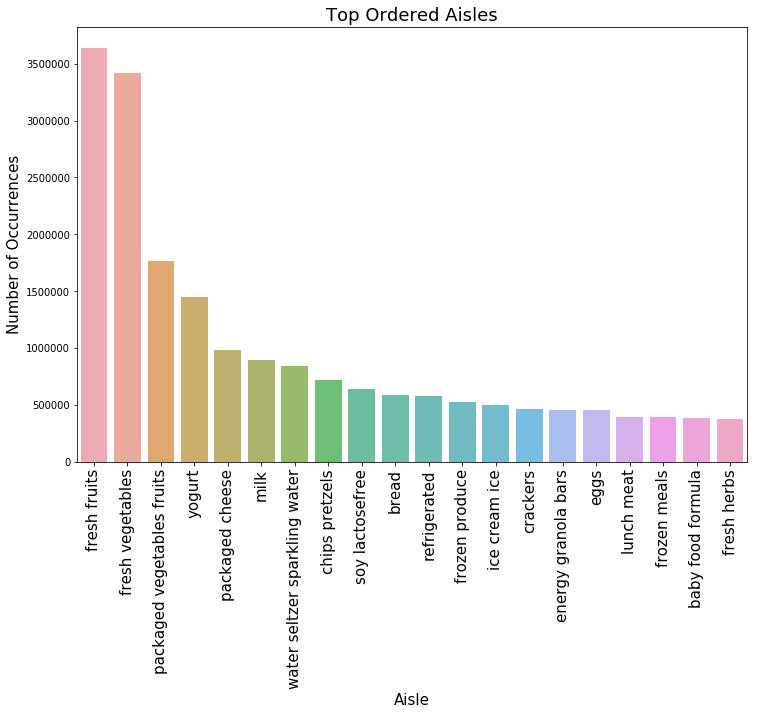

In [43]:
cnt_ailes = df_order_products_prior['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_ailes.index, cnt_ailes.values, alpha=0.8)
plt.title("Top Ordered Aisles", fontsize=18)
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Aisle', fontsize=15)
plt.xticks(rotation='vertical', fontsize = 15)
plt.show()

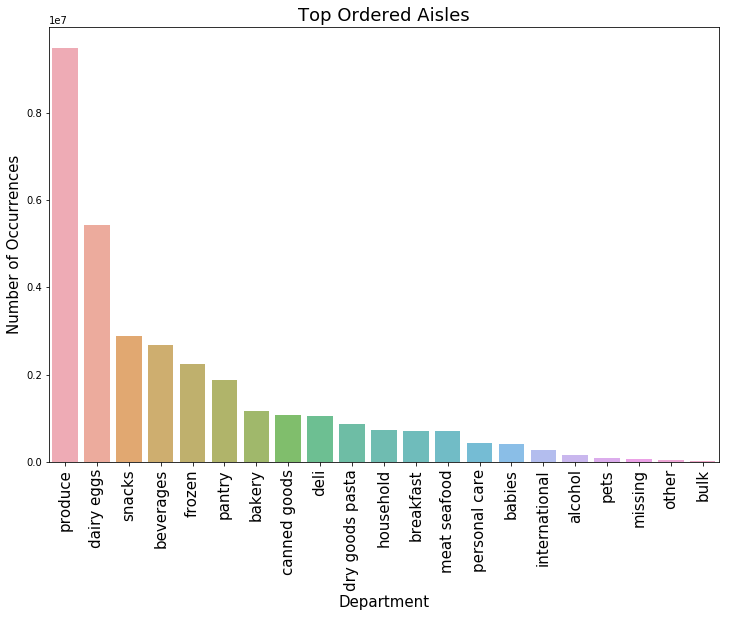

In [44]:
cnt_ailes = df_order_products_prior['department'].value_counts()
plt.figure(figsize=(12,8))
sns.barplot(cnt_ailes.index, cnt_ailes.values, alpha=0.8)
plt.title("Top Ordered Aisles", fontsize=18)
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Department', fontsize=15)
plt.xticks(rotation='vertical', fontsize = 15)
plt.show()

Proportion of orders by department

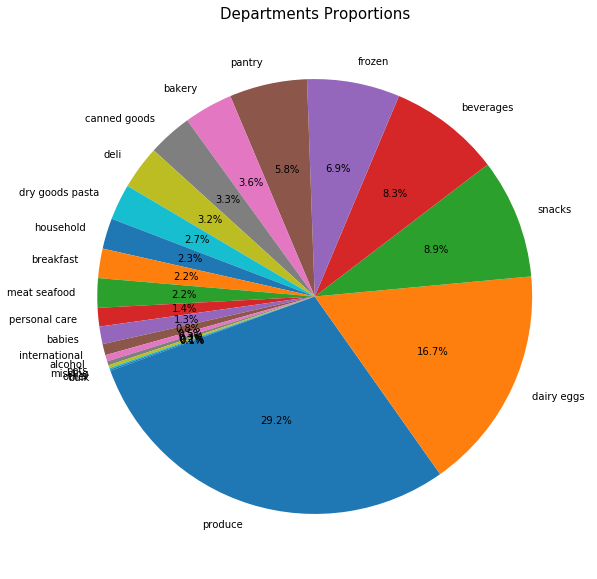

In [73]:
plt.figure(figsize=(10,10))
temp_series = df_order_products_prior['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments Proportions", fontsize=15)
plt.show()

# Reorder Analysis

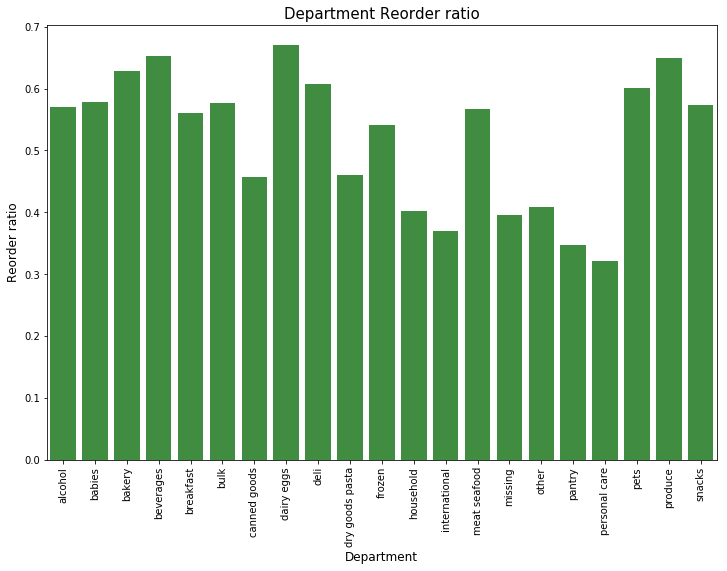

In [45]:
df_grouped = df_order_products_prior.groupby(
   ['department']
).agg(
    {
        'reordered': 'mean'
              
    }
).reset_index()


plt.figure(figsize=(12,8))
sns.barplot(df_grouped['department'].values, df_grouped['reordered'].values, alpha=0.8, color='g')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

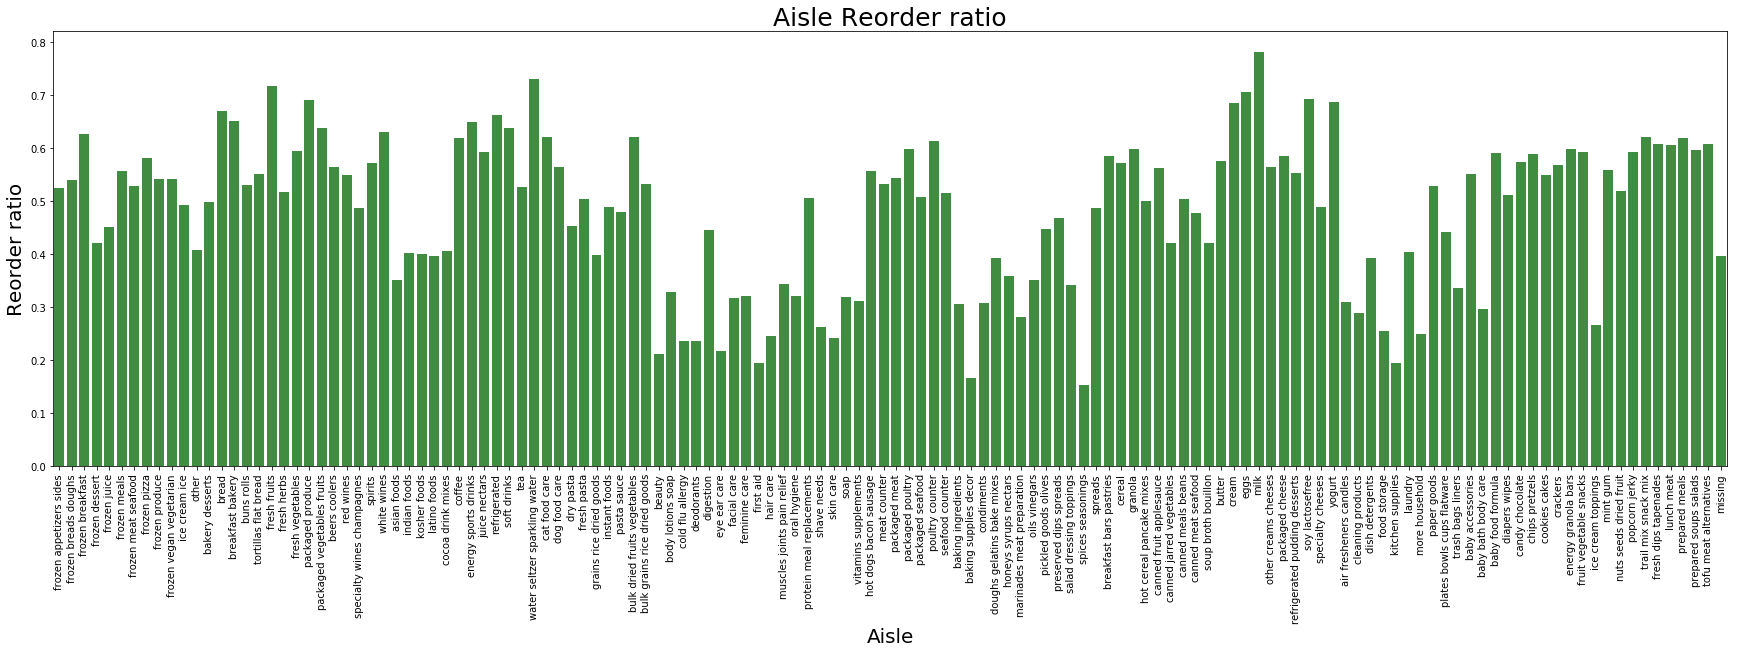

In [46]:
df_grouped = df_order_products_prior.groupby(
   ['department_id', 'aisle']
).agg(
    {
        'reordered': 'mean'
              
    }
).reset_index()


plt.figure(figsize=(30,8))
sns.barplot(df_grouped['aisle'].values, df_grouped['reordered'].values, alpha=0.8, color='g')
plt.ylabel('Reorder ratio', fontsize=20)
plt.xlabel('Aisle', fontsize=20)
plt.title("Aisle Reorder ratio", fontsize=25)
plt.xticks(rotation='vertical')
plt.show()

Reorders by what order a product was added to the cart

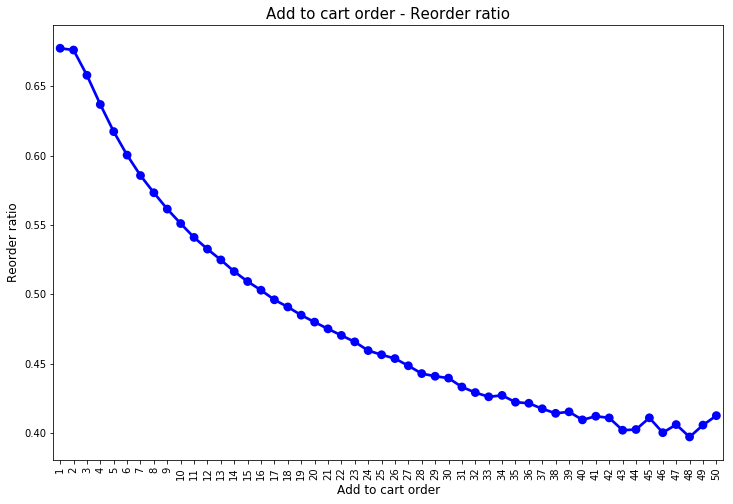

In [48]:
df_order_products_prior["add_to_cart_order_mod"] = df_order_products_prior["add_to_cart_order"].copy()
df_order_products_prior["add_to_cart_order_mod"].loc[df_order_products_prior["add_to_cart_order_mod"]>50] = 50

df_grouped = df_order_products_prior.groupby(
   ['add_to_cart_order_mod']
).agg(
    {
        'reordered': 'mean'
              
    }
).reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(df_grouped['add_to_cart_order_mod'].values, df_grouped['reordered'].values, color='b')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

re order ration by day of week and hour of day

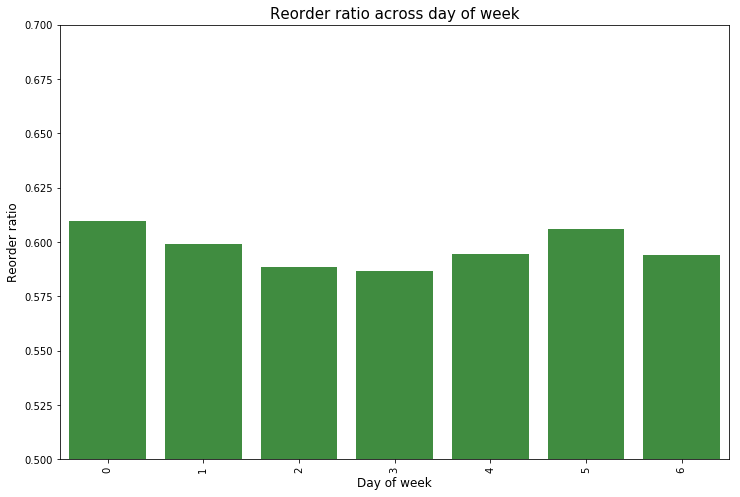

In [49]:
df_order_products_train = pd.merge(df_order_products_train, df_orders, on='order_id', how='left')

df_grouped = df_order_products_train.groupby(
   ['order_dow']
).agg(
    {
        'reordered': 'mean'
              
    }
).reset_index()

plt.figure(figsize=(12,8))
sns.barplot(df_grouped['order_dow'].values, df_grouped['reordered'].values, alpha=0.8, color='g')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

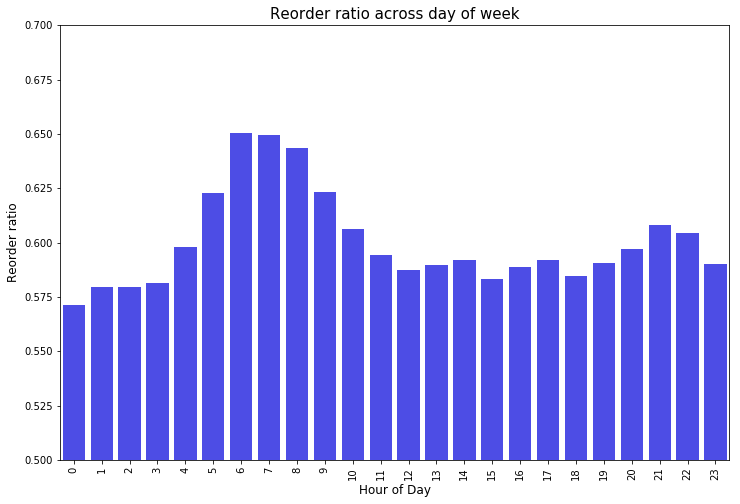

In [50]:
df_grouped = df_order_products_train.groupby(
   ['order_hour_of_day']
).agg(
    {
        'reordered': 'mean'
              
    }
).reset_index()

plt.figure(figsize=(12,8))
sns.barplot(df_grouped['order_hour_of_day'].values, df_grouped['reordered'].values, alpha=0.8, color='b')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of Day', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

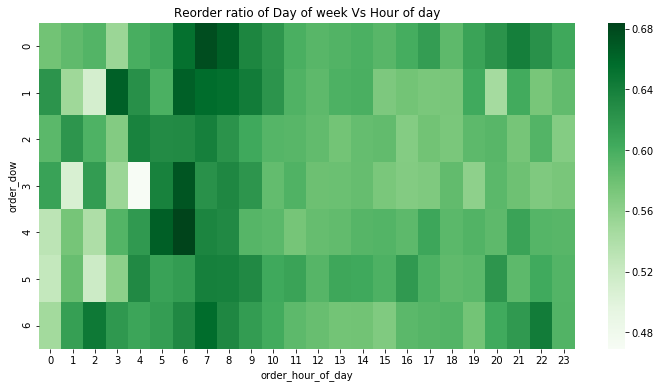

In [53]:
df_grouped = df_order_products_train.groupby(
   ['order_dow', 'order_hour_of_day']
).agg(
    {
        'reordered': 'mean'
              
    }
).reset_index()

df_grouped = df_grouped.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(df_grouped, cmap="Greens")
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

# Product Association Analysis

In [54]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value
orders = df_order_products_prior.set_index('order_id')['product_id'].rename('item_id')
display(orders.head(10))
type(orders)

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

pandas.core.series.Series

In [55]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().to_numpy()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]   

In [56]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [57]:
%%time
rules = association_rules(orders, 0.01) 

Starting order_item:               32434489
Items with support >= 0.01:           10906
Remaining order_item:              29843570
Remaining orders with 2+ items:     3013325
Remaining order_item:              29662716
Item pairs:                        30622410
Item pairs with support >= 0.01:      48751

Wall time: 4min 18s


In [58]:
# Replace item ID with item name and display association rules
item_name   = df_products
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Organic Strawberry Chia Lowfat 2% Cottage Cheese,Organic Cottage Cheese Blueberry Acai Chia,306,0.010155,1163,0.038595,839,0.027843,0.263113,0.364720,9.449868
1,Grain Free Chicken Formula Cat Food,Grain Free Turkey Formula Cat Food,318,0.010553,1809,0.060033,879,0.029170,0.175788,0.361775,6.026229
3,Organic Fruit Yogurt Smoothie Mixed Berry,Apple Blueberry Fruit Yogurt Smoothie,349,0.011582,1518,0.050376,1249,0.041449,0.229908,0.279424,5.546732
9,Nonfat Strawberry With Fruit On The Bottom Gre...,"0% Greek, Blueberry on the Bottom Yogurt",409,0.013573,1666,0.055288,1391,0.046162,0.245498,0.294033,5.318230
10,Organic Grapefruit Ginger Sparkling Yerba Mate,Cranberry Pomegranate Sparkling Yerba Mate,351,0.011648,1731,0.057445,1149,0.038131,0.202773,0.305483,5.317849
...,...,...,...,...,...,...,...,...,...,...,...
7271,Organic Strawberries,Strawberries,640,0.021239,263416,8.741706,141805,4.705931,0.002430,0.004513,0.000516
6763,Organic Hass Avocado,Organic Avocado,464,0.015398,212785,7.061469,176241,5.848722,0.002181,0.002633,0.000373
4387,Organic Avocado,Organic Hass Avocado,443,0.014701,176241,5.848722,212785,7.061469,0.002514,0.002082,0.000356
2596,Banana,Bag of Organic Bananas,654,0.021704,470096,15.600574,376367,12.490090,0.001391,0.001738,0.000111


# Deep Learning Collaborative Filtering Recommender System

In [59]:
# get the list of orders that have been reordered before
reorders = df_order_products_train[df_order_products_train['reordered'] == 1]
reorders.shape

(828824, 11)

In [60]:
orders2 = df_orders[['order_id', 'user_id']]
orders2.head()

,order_id,user_id
0,2539329,1
1,2398795,1
2,473747,1
3,2254736,1
4,431534,1


In [64]:
# merge to get user_id and product_id
user_orders = reorders.merge(orders2, on=['order_id', 'user_id'])
user_orders = user_orders.merge(df_products, on='product_id')

In [65]:
user_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,dayofweek,product_name,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9.0,Thursday,Bulgarian Yogurt,120,16
1,816049,49302,7,1,47901,train,14,4,6,16.0,Thursday,Bulgarian Yogurt,120,16
2,1242203,49302,1,1,2993,train,15,0,7,7.0,Sunday,Bulgarian Yogurt,120,16
3,1383349,49302,11,1,41425,train,4,3,8,14.0,Wednesday,Bulgarian Yogurt,120,16
4,2445303,49302,2,1,199120,train,49,3,20,7.0,Wednesday,Bulgarian Yogurt,120,16


In [66]:
# filtering out the high volumn products that user reordered more than once
user_orders['high_volume'] = (user_orders['product_id'].value_counts().sort_values(ascending=False)>1)
high_volume = user_orders[user_orders['high_volume'] == True]
high_volume.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,dayofweek,product_name,aisle_id,department_id,high_volume
1,816049,49302,7,1,47901,train,14,4,6,16.0,Thursday,Bulgarian Yogurt,120,16,True
3,1383349,49302,11,1,41425,train,4,3,8,14.0,Wednesday,Bulgarian Yogurt,120,16,True
4,2445303,49302,2,1,199120,train,49,3,20,7.0,Wednesday,Bulgarian Yogurt,120,16,True
8,68474,11109,8,1,67333,train,14,4,17,4.0,Thursday,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,True
9,78197,11109,3,1,158104,train,5,5,18,27.0,Friday,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,True


In [67]:
# get a matrix of different high volume items that particular user purchased
high_volume_users = high_volume.groupby(['user_id', 'product_name']).size().sort_values(ascending=False).unstack().fillna(0)

In [68]:
# calculate similarity between each user
cosine_dists = pd.DataFrame(cosine_similarity(high_volume_users),index=high_volume_users.index, columns=high_volume_users.index)
cosine_dists.head()

user_id,5,42,50,59,62,64,71,86,89,91,...,206082,206108,206126,206128,206132,206153,206177,206190,206191,206205
user_id,,,,,,,,,,,,,,,,,,,,,
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.707107,0.0,0.0,0.0,0.0
42,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0
50,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.707107,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
59,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.707107,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [69]:
def Recommender_System(user_id):
    
    '''
    enter user_id and return a list of 5 recommendations.
    '''
    
    u = high_volume.groupby(['user_id','product_name']).size().sort_values(ascending=False).unstack().fillna(0)
    u_sim = pd.DataFrame(cosine_similarity(u), index=u.index, columns=u.index)

    p = high_volume.groupby(['product_name','user_id']).size().sort_values(ascending=False).unstack().fillna(0)
    
    recommendations = pd.Series(np.dot(p.values,cosine_dists[user_id]), index=p.index)
    return recommendations.sort_values(ascending=False).head()

In [70]:
#gives a random user ID to for input to the recommender system
random.sample(high_volume['user_id'].tolist(),1)

[110999]

In [71]:
Recommender_System(110999)

product_name
Organic Baby Arugula               475.834143
Organic Unsweetened Almond Milk    396.189613
Natural Spring Water               173.044398
Bag of Organic Bananas              69.015612
Organic Garlic                      21.204684
dtype: float64

In [72]:
random_user_recs = df_order_products_train.merge(df_orders, on='order_id', how='left').merge(df_products, on='product_id', how='left')

In [73]:
random_user_recs.head()

,order_id,product_id,add_to_cart_order,reordered,user_id_x,eval_set_x,order_number_x,order_dow_x,order_hour_of_day_x,days_since_prior_order_x,...,user_id_y,eval_set_y,order_number_y,order_dow_y,order_hour_of_day_y,days_since_prior_order_y,dayofweek_y,product_name,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9.0,...,112108,train,4,4,10,9.0,Thursday,Bulgarian Yogurt,120,16
1,1,11109,2,1,112108,train,4,4,10,9.0,...,112108,train,4,4,10,9.0,Thursday,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
2,1,10246,3,0,112108,train,4,4,10,9.0,...,112108,train,4,4,10,9.0,Thursday,Organic Celery Hearts,83,4
3,1,49683,4,0,112108,train,4,4,10,9.0,...,112108,train,4,4,10,9.0,Thursday,Cucumber Kirby,83,4
4,1,43633,5,1,112108,train,4,4,10,9.0,...,112108,train,4,4,10,9.0,Thursday,Lightly Smoked Sardines in Olive Oil,95,15


In [75]:
random_user_recs[random_user_recs.user_id_x == 147855].product_name.value_counts().head(20)

Non Fat Raspberry Yogurt                          1
Roasted Red Pepper Hummus                         1
Organic Fresh Basil                               1
Grated Parmesan                                   1
Organic Strawberries                              1
Honey Nut Cheerios                                1
Organic Black Beans                               1
Organic Raw Kombucha Gingerade                    1
Banana                                            1
Icelandic Style Fat Free Plain Yogurt             1
Organic Blackberries                              1
Kombucha, Organic Raw, Citrus                     1
Non GMO Organic Brown Eggs                        1
Master Brew Kombucha, Tart Cherry                 1
Organic Kosher Dill Pickles                       1
Naturals Chicken Nuggets                          1
Red Vine Tomato                                   1
Wheat Sandwich Thins                              1
Organic Low Sodium Vegetable Broth                1
Organic Pear

In [77]:
random.sample(high_volume['user_id'].tolist(),1)

[201169]

In [78]:
Recommender_System(201169)

product_name
Bag of Organic Bananas    5517.598405
Organic Raspberries        201.361468
Organic Blueberries         96.726958
Organic Yellow Onion        77.206508
Organic Garlic              76.045687
dtype: float64

In [79]:
random_user_recs[random_user_recs.user_id_x == 175965].product_name.value_counts().head(20)

Unsweetened Vanilla Almond Milk                                  1
Organic Large Extra Fancy Fuji Apple                             1
Raw Probiotics Women probiotic 85 Billion 32 Strains capsules    1
Organic Garlic                                                   1
Creamy Peanut Butter                                             1
Organic Roasted Turkey Breast                                    1
Organic SprouTofu Silken Tofu                                    1
Blue Chips Corn Tortilla Chips                                   1
Organic Baby Carrots                                             1
Organic Granny Smith Apple                                       1
Organic Hot Italian Chicken Sausage                              1
Sweet Onion                                                      1
Organic Carrot Bunch                                             1
Natural Free & Clear Dishwasher Detergent Packs                  1
Name: product_name, dtype: int64

In [81]:
users = high_volume.user_id.unique().tolist()

In [83]:
def how_match():
    res = []
    for user in sorted(users)[6000:]:
        recommendations = Recommender_System(user)
        top_20_itmes = _[_.user_id_x == user].product_name.value_counts().head(20)
    
        recommendations_list = recommendations.index.tolist()
        top_20_items_list = top_20_itmes.index.tolist()
    
        res.append((len(set(recommendations_list) & set(top_20_items_list)))/5)
    return np.mean(res)

In [82]:
# get metric for 6000: users
#how_match()

# ======================================================
# ======================================================
# ======================================================

## Collaborative filtering for recommendation systems
### SVD with Python library `surprise`

In [26]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
color = sns.color_palette()

%matplotlib inline

import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity 

pd.options.mode.chained_assignment = None  # default='warn'

In [27]:
# already read in above- copied here for reference
os.chdir(r'C:\Users\william.block\Desktop\Machine Learning\non_git\recommendation_systems\data')
df_aisles = pd.read_csv('aisles.csv')
df_departments = pd.read_csv('departments.csv')
df_order_products_prior = pd.read_csv('order_products__prior.csv')
df_order_products_train = pd.read_csv('order_products__train.csv')
df_orders = pd.read_csv('orders.csv')
df_products = pd.read_csv('products.csv')

### Install scikit-surprise

See https://anaconda.org/conda-forge/scikit-surprise

Analysis based on the following public Kaggle notebook: https://www.kaggle.com/ouwyukha/imba-surprise-svd

Nice demo of `surprise` library here: https://towardsdatascience.com/machine-learning-for-building-recommender-system-in-python-9e4922dd7e97

In [28]:
from surprise import Reader, Dataset
from surprise import SVD
from multiprocessing import Pool
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())


0it [00:00, ?it/s]


In [29]:
# get original record count for dataframes
print(f'df_orders=\t\t\t{len(df_orders)}\n' 
      f'df_order_products_prior=\t{len(df_order_products_prior)}\n'
     f'df_order_products_train=\t{len(df_order_products_train)}\n'
     f'df_products=\t\t\t{len(df_products)}')

df_orders=			3421083
df_order_products_prior=	32434489
df_order_products_train=	1384617
df_products=			49688


### Data cleaning

In [30]:
#drop any records with missing data
df_orders.dropna(inplace = True)
df_order_products_prior.dropna(inplace = True)
df_order_products_train.dropna(inplace = True)
df_products.dropna(inplace = True)

In [31]:
# get record count for dataframes after dropping records with missing data
print(f'df_orders=\t\t\t{len(df_orders)}\n' 
      f'df_order_products_prior=\t{len(df_order_products_prior)}\n'
     f'df_order_products_train=\t{len(df_order_products_train)}\n'
     f'df_products=\t\t\t{len(df_products)}')

df_orders=			3214874
df_order_products_prior=	32434489
df_order_products_train=	1384617
df_products=			49688


*Still plenty of good data to work with...*

### Data transformation

In [32]:
# combine the two (train and prior) product order datasets
df_order_products = pd.concat([df_order_products_prior, df_order_products_train])

In [33]:
# merge the product order data with the order dataset
df_orders_colsubset = df_orders[['order_id','user_id']]
df_order_products_merged = pd.merge(df_order_products, df_orders_colsubset, on = 'order_id').drop('order_id', axis = 1)

In [34]:
# peek the data
df_order_products_merged.head()

,product_id,add_to_cart_order,reordered,user_id
0,33120,1,1,202279
1,28985,2,1,202279
2,9327,3,0,202279
3,45918,4,1,202279
4,30035,5,0,202279


### Calculate a score for each product by user

In [35]:
# calculate a score for each product by user
df_reordered_counts = pd.DataFrame(df_order_products_merged.groupby(['user_id','product_id']).reordered \
                        .sum())
df_reordered_counts.rename(columns = {'reordered' : 'reordered_count'}, inplace = True)
df_reordered_counts.head()

reordered_count
user_id product_id                 
1       196                      10
        10258                     9
        10326                     0
        12427                     9
        13032                     3

In [36]:
# join back to product orders df
df_product_order_counts = pd.merge(df_order_products_merged, 
                                   df_reordered_counts,
                                   on=['user_id','product_id'], 
                                   how='left')
df_product_order_counts.head()

,product_id,add_to_cart_order,reordered,user_id,reordered_count
0,33120,1,1,202279,5
1,28985,2,1,202279,4
2,9327,3,0,202279,0
3,45918,4,1,202279,4
4,30035,5,0,202279,2


In [38]:
# keep only products reordered more than 20 times
# doing this purely to cut down on data size/ processing time?
# df_product_data = df_product_order_counts[df_product_order_counts.reordered_count > 20]
df_product_data = df_product_order_counts
# calculate score
df_product_data['target'] = np.log(df_product_data['reordered_count']+1)

### Conform data to `surprise` standards

From [Towards Data Science:](https://towardsdatascience.com/machine-learning-for-building-recommender-system-in-python-9e4922dd7e97)

"The Reader class in Surprise is to parse a file containing users, items, and users’ ratings on items. The default format is that each rating is stored in a separate line in the following order separated by space: *user item rating*"

In [39]:
# clean up df
df_product_data.drop(['reordered','reordered_count','add_to_cart_order'],axis=1,inplace=True)
df_product_data.head()

,product_id,user_id,target
0,33120,202279,1.791759
1,28985,202279,1.609438
2,9327,202279,0.000000
3,45918,202279,1.609438
4,30035,202279,1.098612


In [40]:
#set up test dataset - user_id column only
df_orders_test = df_orders[df_orders.eval_set == 'test'][['user_id']]

In [41]:
# get list of unique user and product IDs, and list of top products by user
productIDs = df_product_data.product_id.unique()
userIDs = df_product_data.user_id.unique()
watchedList = df_product_data.groupby('user_id')['product_id'].apply(list).to_dict()

In [42]:
# save data for tracking
df_orders_bkp = df_orders[df_orders.eval_set == 'test'][['order_id','user_id']]

In [43]:
# conform to surprise df
reader = Reader(rating_scale= (df_product_data.target.min(), df_product_data.target.max()))
data_train = Dataset.load_from_df(df_product_data, reader)
trainset = data_train.build_full_trainset()

In [44]:
type(trainset)

surprise.trainset.Trainset

In [45]:
trainset.rating_scale

(0.0, 4.605170185988092)

In [46]:
trainset.n_items

206209

### Training 

In [47]:
%%time
model = SVD(verbose=1,random_state=0).fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Wall time: 36min 12s


### Prediction 

In [48]:
# define function to help with prediction

def predict(user):
    pred = []
    if isinstance(user, pd.DataFrame) or isinstance(user, pd.Series):
        user_id = user.user_id
    elif isinstance(user, int) or isinstance(user, np.int64):
        user_id = user
    else:
        raise Exception("user arg to predict func must be type int or pd.DataFrame (row)")
            
    for x in productIDs:
        try:
            if x in watchedList[user_id]:
                pred.append((x,model.predict(user_id,x).est))
        except KeyError as e:
            continue
    pred = sorted(pred, key = lambda x: x[1], reverse=True)
    if not pred:
        return (np.nan, np.nan)
    return pred

In [49]:
# test prediction on a single user
#sample_user_id = df_orders_test.user_id.sample(random_state = 14).values[0]
sample_user_id = 196579  # lock-in

In [50]:
# Testing predictions for a bunch of random users
# Note that we don't have predictions for a lot of users-  just not enough data? 
# Find a good example (lots of predictions) and run with it for demo

for i in range(50):
    #suid = pd.Series(list(watchedList.keys())).sample().values[0]
    suid = df_orders_test.user_id.sample().values[0]
    print(f"UserID={suid} --> {predict(suid)}")

UserID=196579 --> [(19604, 2.0867030391525327), (38739, 1.980879035441776), (46126, 1.9157184163567145), (19006, 1.8942457150495613), (6568, 1.8392535395246072), (3856, 1.7986349430642288), (39599, 1.7840414659232506), (37208, 1.7830700574444671), (31956, 1.7723252299818022), (28281, 1.7678547138624636), (26444, 1.7606186950732594), (5189, 1.742736761458919), (32638, 1.7028655981175511), (2229, 1.681648239730604), (23204, 1.624772151568241), (46023, 1.6065632587719227), (11422, 1.5973994955128548), (19156, 1.5964722586416893), (14576, 1.5888674836708432), (30759, 1.5856504281612447), (23296, 1.5832510972660951), (21784, 1.5759037356753938), (33129, 1.5708089414148378), (15518, 1.5700329404395565), (5077, 1.5526911920489743), (40151, 1.550409411975445), (3919, 1.5488903644232095), (13263, 1.5387036810213006), (12811, 1.522303430164575), (48527, 1.517348246729531), (37940, 1.5151335587393526), (13149, 1.5100305720494442), (45104, 1.4875812197187583), (33552, 1.4805546339246785), (18281, 

## TODO: 
#### 1. Find a good example user based on random sampling above (i.e. good number of product score predictions)
#### 2. Analyze user's past orders-  create plots for most purchased items, etc, so we can get to know the user and understand if the recommendations are good ones
#### 3. Predict using model - join back IDs to product names and visualize against the past order information
#### 4. Clean up notebook

In [56]:
df_user = pd.DataFrame(predict(sample_user_id),columns=['product_id','score'])
df_user

,product_id,score
0,41220,1.636532
1,32043,1.512073
2,203,1.483930
3,42265,1.295427
4,47119,1.275404
5,535,1.032704
6,6474,0.904359
7,20228,0.816921
8,14233,0.752295


In [57]:
df_products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [63]:
df_product_name = df_user.join(df_products, on = 'product_id', how = 'left', rsuffix = '_product')
df_product_name = df_product_name[['product_name','score']]
df_product_name

,product_name,score
0,Sunscreen Mineral Defense Kids SPF 30,1.636532
1,Seltzer Calorie-free Cranberry Lime,1.512073
2,Free & Clear Natural Laundry Detergent For Sen...,1.483930
3,Vanilla Almond African Black Soap,1.295427
4,Chicken Flavored Mexican Rice,1.275404
5,Belgian Waffles,1.032704
6,Limonata Sparkling Lemon Beverage,0.904359
7,Supersweet Corn,0.816921
8,Electric Blue Sparkling Sugar,0.752295


In [22]:
# prediction
"""
num_cores = 4
num_partitions = num_cores
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def coba_mp_apply(data):
    data['predictions'] = data.progress_apply(predict, axis=1).values
    return data.explode('predictions')
    
rresults = parallelize_dataframe(df_orders_test, coba_mp_apply)
"""

"\nnum_cores = 4\nnum_partitions = num_cores\ndef parallelize_dataframe(df, func):\n    df_split = np.array_split(df, num_partitions)\n    pool = Pool(num_cores)\n    df = pd.concat(pool.map(func, df_split))\n    pool.close()\n    pool.join()\n    return df\n\ndef coba_mp_apply(data):\n    data['predictions'] = data.progress_apply(predict, axis=1).values\n    return data.explode('predictions')\n    \nrresults = parallelize_dataframe(df_orders_test, coba_mp_apply)\n"